# HW1 auto stock trading

I learned two kinds of prediction using machine learning. One is **classification**, which will divide inputs into several groups. The other one is **regression**, which will predict the exactly value of the query.

After some survey on stock predictioin, the two prediction are used, but to know which one is the best and which model is the best are to be tested and analyzed.

## Predict with classification
In my experience, people usually predict stock with status instead of the precise value. Plus, the actions we can do are buy, sell and sell short. Thus deciding the action by predicting the trend of the stock we're holding is straightforward.

### Using SVC (support vector classifier) 
**using SVC default kernel (rbf)**

Below is my strategy:
The prediction output will be the group number
1. Divide the input into three groups:
    * `1`: nextDay_open - ToDay_open > 0, if the price is rising
    * `-1`: nextDay_open - ToDay_open < 0, if the price is going down
    * `0`: else
2. Train with SVC
    * there're three different models: rbf, linear and poly
    * parameters could be tested till I find the best one
    * use all four prices everyday to train
3. Test with testing data
    * according the prediction to decide whether to buy it or not, also we should consider the unit we hold
    * predict `1`: I'll buy, since it's rising
    * predict `-1`: I'll sell, since it's falling
    * `0`: hold
    
    
### Library

In [1]:
import csv                                                                                         
from collections import OrderedDict
from sklearn.svm import SVC 
import matplotlib.pyplot as plt 

### Load data

In [2]:
# load data, using all four prices
def load_data(filename):
    ret_list = []
    with open(filename, 'rt') as csvfile:
        cin = csv.reader(csvfile)
        for row in cin:
            a = [float(row[0]), float(row[1]), float(row[2]), float(row[3])]
            ret_list.append(list(a))
    return ret_list

# read in training data
training_data = load_data('training_data.csv')

# read in testing data
testing_data = load_data('testing_data.csv')
testing_last_data = testing_data.pop()

### class Trader

* init: init model, holding unit, money and action
* train function: training model
* predict_action: predict

In [3]:
class Trader():
    def __init__(self, kernel):
        self.clf = SVC(kernel=kernel)
        self.unit = 0
        self.pre_act = 0
        self.money = 0
        
    def train(self, training_data):
        # init groups for every trainging data: 1, 0, -1  
        y = []
        for i in range(0, len(training_data) - 1):
            ToDayOpen = training_data[i][0]
            nextOpen = training_data[i + 1][0]
            if (nextOpen - ToDayOpen) > 0: 
                y.append(1)
            elif (nextOpen - ToDayOpen) < 0:
                y.append(-1)
            else:
                y.append(0)
        self.clf.fit(training_data[0:-1], y)
        return
    
    def predict_action(self, test_datum):
        act = self.clf.predict([test_datum])[0]
        
        # Check if the unit is valid after action
        if (self.unit + act) > 1:
            act = 0
        elif (self.unit + act) < -1:
            act = 0

        # Update money
        if self.pre_act == 1:
            self.money -= test_datum[0]
        elif self.pre_act == -1: 
            self.money += test_datum[0]

        self.unit = self.unit + act 
        self.pre_act = act 

        return str(act)
    
    def get_profit(self, last_data):
        # execute the last day action
        if self.pre_act == 1:
            self.money -= testing_last_data[0]
        elif self.pre_act == -1:
            self.money += testing_last_data[0]
        
        # clear holding unit
        if self.pre_act + self.unit == 1:
            self.money += testing_last_data[1]
        elif self.unit + self.pre_act == -1:
            self.money -= testing_last_data[1]
        return self.money

### Test with different SVM kernel

* create

In [4]:
svc_rbf = Trader("rbf")
svc_lin = Trader("linear")

* Train

In [5]:
svc_rbf.train(training_data)
svc_lin.train(training_data)

In [6]:
# predict
for row in testing_data:
    svc_rbf.predict_action(row)
    svc_lin.predict_action(row)


### Result profit

In [7]:
print('svc rbf: ', svc_rbf.get_profit(testing_last_data))
print('svc linear: ', svc_lin.get_profit(testing_last_data))


svc rbf:  -132.93021300000004
svc linear:  -13.47228699999971


## Utilization 1 -- observe training data

We use all for different prices in a day to train our prediction model, but do we really need to consider these four prices? Or if the some of them are just disturbing the training? So I decided to observe the training data.

### Trend
From picture below, we can see that the trend of each prices is almost the same.
Just observe with eyes, it is hardly to see open price and close price since they're all between in high and low prices.

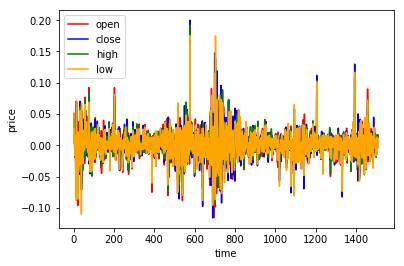

In [8]:
openp = []
closep = []
highp = []
lowp = []
days = range(1, len(training_data))
for i in range(0, len(training_data) - 1):
    openp.append((training_data[i + 1][0] - training_data[i][0]) / training_data[i][0])
    highp.append((training_data[i + 1][1] - training_data[i][1]) / training_data[i][1])
    lowp.append((training_data[i + 1][2] - training_data[i][2]) / training_data[i][2])
    closep.append((training_data[i + 1][3] - training_data[i][3]) / training_data[i][3])
    
plt.plot(days, openp, color='red', label='open')
plt.plot(days, closep, color='blue', label='close')
plt.plot(days, highp, color='green', label='high')
plt.plot(days, lowp, color='orange', label='low')
plt.xlabel('time')
plt.ylabel('price')
plt.legend()
plt.show()

For more closer look, we can calculate the correlation coefficient between each other. 

In [9]:
import numpy as np
print(np.corrcoef([openp, highp, lowp, closep]))

[[1.         0.74253352 0.70781009 0.33900979]
 [0.74253352 1.         0.74841206 0.71723567]
 [0.70781009 0.74841206 1.         0.70485976]
 [0.33900979 0.71723567 0.70485976 1.        ]]


### Conclusion

from the above result, `open price` is more correlated with `high price` and `low price`. Thus I decide not to use `close price`. 

In [45]:
class Trader():
    def __init__(self, kernel):
        self.clf = SVC(kernel=kernel)
        self.unit = 0
        self.pre_act = 0
        self.money = 0
        
    def train(self, training_data):
        # init groups for every trainging data: 1, 0, -1  
        y = []
        td = [list([training_data[0][0], training_data[0][1], training_data[0][2]])]
        
        for i in range(0, len(training_data) - 1):
            ToDayOpen = training_data[i][0]
            nextOpen = training_data[i + 1][0]
            td.append(list([training_data[i + 1][0], training_data[i + 1][1], training_data[i + 1][2]]))

            if (nextOpen - ToDayOpen) > 0: 
                y.append(1)
            elif (nextOpen - ToDayOpen) < 0:
                y.append(-1)
            else:
                y.append(0)

        self.clf.fit(td[0:-1], y)
        return
    
    def predict_action(self, test_datum):
        act = self.clf.predict([test_datum])[0]
        
        # Check if the unit is valid after action
        if (self.unit + act) > 1:
            act = 0
        elif (self.unit + act) < -1:
            act = 0

        # Update money
        if self.pre_act == 1:
            self.money -= test_datum[0]
        elif self.pre_act == -1: 
            self.money += test_datum[0]

        self.unit = self.unit + act 
        self.pre_act = act 

        return str(act)
    
    def get_profit(self, testing_last_data):
        # execute the last day action
        if self.pre_act == 1:
            self.money -= testing_last_data[0]
        elif self.pre_act == -1:
            self.money += testing_last_data[0]
        
        # clear holding unit
        if self.pre_act + self.unit == 1:
            self.money += testing_last_data[1]
        elif self.unit + self.pre_act == -1:
            self.money -= testing_last_data[1]
            
        return self.money

### Rerun

In [46]:
# create model
svc_rbf = Trader("rbf")
svc_lin = Trader("linear")

# train
svc_rbf.train(training_data)
svc_lin.train(training_data)

# predict
for row in testing_data:
    svc_rbf.predict_action([row[0], row[1], row[2]])
    svc_lin.predict_action([row[0], row[1], row[2]])
    
# get profit
print('svc rbf: ', svc_rbf.get_profit(testing_last_data))
print('svc linear: ', svc_lin.get_profit(testing_last_data))

svc rbf:  22.767029999999522
svc linear:  -16.577054999999802


## Utilization 2 -- cross validation

The previous experiment is simple - train with a training set then start the prediction directly.

But is the training result general enough to fit the other test set? Is that possible the trainging model is overfitting?

That is why we need cross validation! Divide training set to several pieces, some will be training data and the other will treat like test set. Thus we can repeatedly verify our model and try to avoid overfitting.

### Library

In [48]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score

In [52]:
y = []
for i in range(0, len(training_data) - 1):
    ToDayOpen = training_data[i][0]
    nextOpen = training_data[i + 1][0]
    if (nextOpen - ToDayOpen) > ToDayOpen * 0.005: 
        y.append(1)
    elif ((nextOpen - ToDayOpen) < 0) and ((ToDayOpen - nextOpen) < ToDayOpen * 0.005):
        y.append(-1)
    else:
        y.append(0)

scores = cross_val_score(svc_rbf.clf, training_data[0:-1], y, cv = 3)
print(scores)
scores = cross_val_score(svc_lin.clf, training_data[0:-1], y, cv = 3)
print(scores)

[0.65148515 0.60437376 0.58366534]
[0.76039604 0.73359841 0.70318725]


## Utilization 3 -- changing investigate strategy

I losed money in my first try, no matter which model I used. 
Firstly, I reconsider my action strategy.

### Change classification
I bought in a unit when the price is rising, but actually I should buy in it is falling and selling out when it starts to rise. Thus I modified the classification to:
* `-1`: nextDay_open - ToDay_open > 0, if the price is rising => **sell**
* `1`: nextDay_open - ToDay_open < 0, if the price is going down => **buy**
* `0`: else